In [1]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

import json

from approaches.gaussian_predictor_levelsets import *
from approaches.gaussian_trainer import *

seed_everything(42)

In [2]:
seed_everything(42)

class RadiusTransformation2:
    def __init__(self, d, beta=None):
        if beta is None:
            beta = np.random.randn(d)
        self.beta = beta

    def get(self, x):
        return ((( np.linalg.norm(x)) / 2.0 + (np.dot(self.beta, x))**2 / 10) / 2 ) / .5 + 0.15

d = 2
hidden_dim = 5
hidden_dim_matrix = 100
k = 3

input_dim = d
output_dim = k

tab_coverage = []
tab_warm_start_covariance_coverage = []
tab_warm_start_local_covariance_coverage = []
tab_hyper_rectangle_coverage = []

pert = "exponential"  

n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000
n_anchors = 10


config_name = "gau_t"

config_path = "../parameters/" + config_name + ".json"
with open(config_path, 'r') as file : 
    parameters = json.load(file)



hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]


num_epochs = parameters["num_epochs"]


batch_size = parameters["batch_size"]

idx_knowned = np.array(parameters["idx_knowned"])

dtype = torch.float32 if parameters["dtype"] == "float32" else torch.float64

alpha = 0.1
print(alpha)

class NonLinearFunction2:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta
        self.proj  = np.zeros((d, k))
        self.proj[0, 0] = 1.0
        self.proj[1, 1] = 1.0

    def get(self, x):
        nonlinear_term = np.sin(np.dot(x, self.beta)) + 0.5 * np.tanh(np.dot(x**2, self.beta)) + np.dot(x, self.proj)
        return nonlinear_term * 2
    
def generate_cov(n):
    covariance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            covariance_matrix[i, j] = 0.5
            if i == j:
                covariance_matrix[i, j] = 1.0
    return covariance_matrix

cov_matrix = generate_cov(k)

f_star = NonLinearFunction2(d, k)
radius = RadiusTransformation2(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=cov_matrix, bias = False, seed = 42)

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



0.1


In [3]:
seed_everything(42)

hidden_dim = 128
num_layers = 3
batch_size = 32
num_epochs = 300
lr = 1e-3

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)

gaussian_trainer = GaussianTrainer(input_dim, 
                            output_dim,
                            hidden_dim = hidden_dim,
                            num_layers = num_layers
                            )

gaussian_trainer.fit(trainloader, 
                    stoploader,
                    num_epochs=num_epochs,
                    lr=lr,
                    verbose = 2
                    )

center_model = gaussian_trainer.center_model
matrix_model = gaussian_trainer.matrix_model

gaussian_predictor = GaussianPredictorLevelsets(center_model, matrix_model, dtype=dtype)

/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/approaches/gaussian_trainer.py:112: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2259.)
  z = torch.triangular_solve(diff, L, upper=False)[0]


Epoch 1: Avg NLL Loss = 2.2197 -- Stop loss: 1.8831 -- Best Stop Loss: inf
Epoch 2: Avg NLL Loss = 1.7060 -- Stop loss: 1.7075 -- Best Stop Loss: 1.8831290062516928
Epoch 3: Avg NLL Loss = 1.6363 -- Stop loss: 1.6740 -- Best Stop Loss: 1.7075194399803877
Epoch 4: Avg NLL Loss = 1.5811 -- Stop loss: 1.6562 -- Best Stop Loss: 1.6740328185260296
Epoch 5: Avg NLL Loss = 1.5529 -- Stop loss: 1.5757 -- Best Stop Loss: 1.6562068108469248
Epoch 6: Avg NLL Loss = 1.5175 -- Stop loss: 1.5989 -- Best Stop Loss: 1.5756781054660678
Epoch 7: Avg NLL Loss = 1.5109 -- Stop loss: 1.5522 -- Best Stop Loss: 1.5756781054660678
Epoch 8: Avg NLL Loss = 1.4852 -- Stop loss: 1.5971 -- Best Stop Loss: 1.552177730947733
Epoch 9: Avg NLL Loss = 1.4773 -- Stop loss: 1.5098 -- Best Stop Loss: 1.552177730947733
Epoch 10: Avg NLL Loss = 1.4590 -- Stop loss: 1.5605 -- Best Stop Loss: 1.5097770504653454
Epoch 11: Avg NLL Loss = 1.4489 -- Stop loss: 1.5138 -- Best Stop Loss: 1.5097770504653454
Epoch 12: Avg NLL Loss = 

In [4]:
gaussian_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)

tensor(2.4792)

In [5]:
projection_matrix = np.zeros((2, k))
projection_matrix[0, 0] = 1.0
projection_matrix[0, 2] = 1.0
projection_matrix[1, 1] = 1.0


projection_matrix = projection_matrix


projection_matrix_tensor = torch.tensor(projection_matrix, dtype=torch.float32)

In [6]:
idx_knowned = np.array([0])
gaussian_predictor.conformalize_linear_projection(
                                            projection_matrix=projection_matrix_tensor,
                                            x_calibration=x_calibration_tensor, 
                                            y_calibration=y_calibration_tensor, 
                                            alpha = alpha
                                            )

tensor(1.9685)

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/plot_data.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same

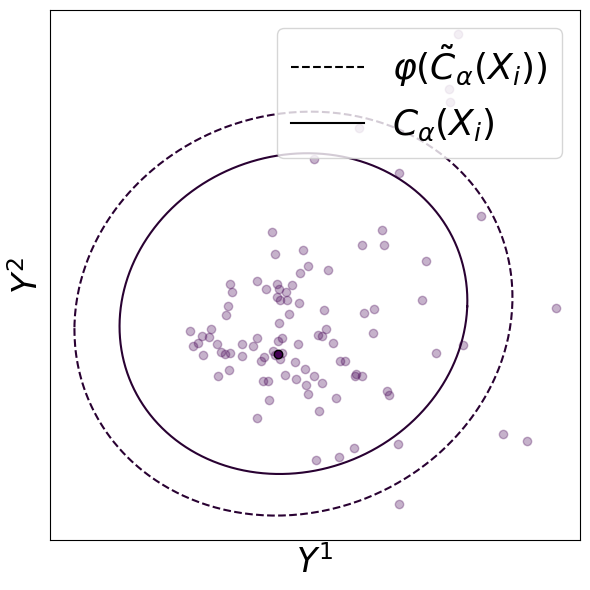

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/plot_data.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same

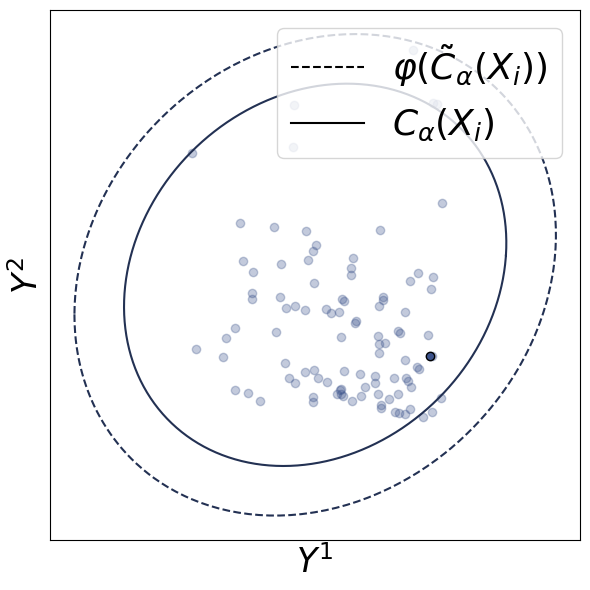

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/plot_data.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same

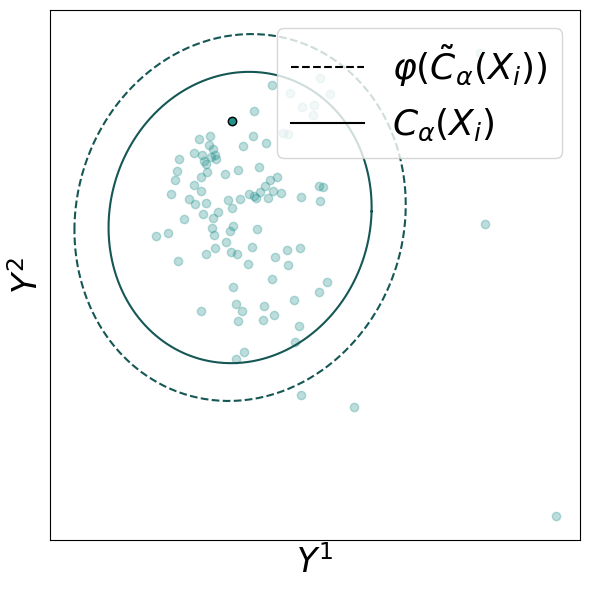

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/plot_data.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/3007692545.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same

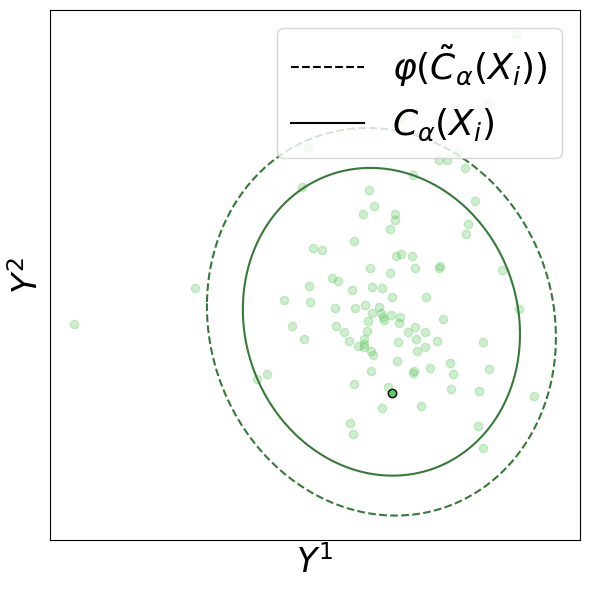

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


tab_seed = [6, 9, 52, 39]
q_val = 2.0
dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 



for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        fig, ax = plt.subplots(figsize=(6, 6))

        color_map = plt.cm.get_cmap('viridis', 5)
        colors = color_map(np.linspace(0, 1, 5))
        darker_colors = colors.copy()
        from matplotlib.colors import ListedColormap
        darker_viridis = ListedColormap(darker_colors)
        darker_colors[:, :3] *= 0.6

        x_specific, y_specific = data_generator.generate_specific_x(100)

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        y_specific_projected = torch.einsum('ik,nk->ni', projection_matrix_tensor, y_specific_tensor)
        y_specific_projected_np = y_specific_projected.detach().numpy()

        centers = gaussian_predictor.get_centers(x_specific_tensor)
        Lambdas_specific = gaussian_predictor.get_Lambdas(x_specific_tensor)

        centers_np = centers.detach().numpy()
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        centers_projected, Lambdas_projected = get_new_centers_Lambdas_with_linear_projection(centers, Lambdas_specific, projection_matrix_tensor)

        centers_projected_np = centers_projected.detach().numpy()
        Lambdas_projected_np = Lambdas_projected.detach().numpy()

        radius = gaussian_predictor.nu_conformal.item()
        radius_proj = gaussian_predictor.nu_conformal_projection.item()

        ax = add_ellipse(ax,  centers_projected_np[0], Lambdas_projected_np[0], q_val, radius_proj, color = darker_viridis(i), label = None )
                  
        ax.scatter(y_specific_projected_np[:, 0], y_specific_projected_np[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific_projected_np[0, 0], y_specific_projected_np[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        ellipse_surface = surface_ellipse_3d(
        centers_np[0], 
        Lambdas_specific_np[0], 
        radius
        )
        
        ellipse_surface_flat = np.array(ellipse_surface).reshape(3, -1)
        projection_matrix_pseudo_inverse = np.linalg.pinv(projection_matrix)
        ellipse_surface_2D = projection_matrix @ ellipse_surface_flat 


        points = ellipse_surface_2D.T
        hull = ConvexHull(points)

        hull_path = np.append(hull.vertices, hull.vertices[0])  # pour fermer l'enveloppe
        plt.plot(points[hull_path, 0], points[hull_path, 1], color=darker_viridis(i), linestyle='--')

        # ax = add_ellipse(ax,  centers_projected_np[0] + np.array([100, 100]), Lambdas_projected_np[0], q_val, radius, color = "black", linestyle='--', label=fr'$\varphi(\tilde{{C}}_\alpha(X_{{i}}))$')
        # ax = add_ellipse(ax,  centers_projected_np[0] + np.array([100, 100]), Lambdas_projected_np[0], q_val, radius, color = "black", linestyle='-', label=fr'$C_\alpha(X_{{i}})$')

        from matplotlib.lines import Line2D

        plt.xticks([])
        plt.yticks([])

        # Entrée pour $\varphi(\tilde{C}_\alpha(X_{i}))$
        legend_phi = Line2D(
        [0], [0],
        color="black",
        linestyle="--",
        linewidth=1.5,
        label=fr"$\varphi(\tilde{{C}}_\alpha(X_{{i}}))$"
        )

        # Entrée pour $C_\alpha(X_{i})$
        legend_C = Line2D(
        [0], [0],
        color="black",
        linestyle="-",
        linewidth=1.5,
        label=fr"$C_\alpha(X_{{i}})$"
        )

        # Ajouter à la légende existante
        handles, labels = ax.get_legend_handles_labels()
        handles.extend([legend_phi, legend_C])
        


        ax.set_xlabel(r'$Y^1$', fontsize=24)
        ax.set_ylabel(r'$Y^2$', fontsize=24)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        ax.legend(fontsize=26, handles=handles, loc="upper right")
        # ax.set_xlim(-3, 15)
        # ax.set_ylim(-6, 5.5)

        plt.tight_layout()

        plt.savefig(f"../figs/proj_{pert}_{seed}_level_sets.png", dpi = 300, bbox_inches='tight')
        plt.savefig(f"../figs/proj_{pert}_{seed}_level_sets.pdf", dpi = 300, bbox_inches='tight')

        plt.show()

        plt.close()

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/610408137.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/Users/sbraun/Desktop/Gaussian_Conformal_Prediction_V2/experiments/code/plot_data.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_24993/610408137.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same R

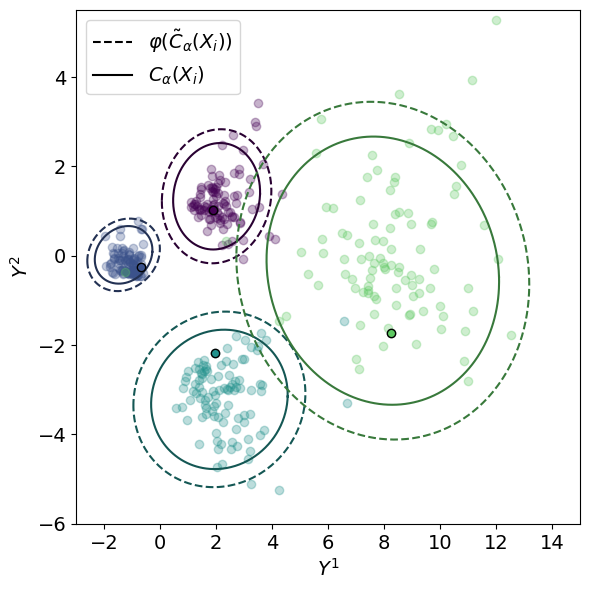

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


tab_seed = [6, 9, 52, 39]
q_val = 2.0
dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        y_specific_projected = torch.einsum('ik,nk->ni', projection_matrix_tensor, y_specific_tensor)
        y_specific_projected_np = y_specific_projected.detach().numpy()

        centers = gaussian_predictor.get_centers(x_specific_tensor)
        Lambdas_specific = gaussian_predictor.get_Lambdas(x_specific_tensor)

        centers_np = centers.detach().numpy()
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        centers_projected, Lambdas_projected = get_new_centers_Lambdas_with_linear_projection(centers, Lambdas_specific, projection_matrix_tensor)

        centers_projected_np = centers_projected.detach().numpy()
        Lambdas_projected_np = Lambdas_projected.detach().numpy()

        radius = gaussian_predictor.nu_conformal.item()
        radius_proj = gaussian_predictor.nu_conformal_projection.item()

        ax = add_ellipse(ax,  centers_projected_np[0], Lambdas_projected_np[0], q_val, radius_proj, color = darker_viridis(i), label = None )
                  
        ax.scatter(y_specific_projected_np[:, 0], y_specific_projected_np[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific_projected_np[0, 0], y_specific_projected_np[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        ellipse_surface = surface_ellipse_3d(
        centers_np[0], 
        Lambdas_specific_np[0], 
        radius
        )
        
        ellipse_surface_flat = np.array(ellipse_surface).reshape(3, -1)
        projection_matrix_pseudo_inverse = np.linalg.pinv(projection_matrix)
        ellipse_surface_2D = projection_matrix @ ellipse_surface_flat 


        points = ellipse_surface_2D.T
        hull = ConvexHull(points)

        hull_path = np.append(hull.vertices, hull.vertices[0])  # pour fermer l'enveloppe
        plt.plot(points[hull_path, 0], points[hull_path, 1], color=darker_viridis(i), linestyle='--')

ax = add_ellipse(ax,  centers_projected_np[0] + np.array([100, 100]), Lambdas_projected_np[0], q_val, radius, color = "black", linestyle='--', label=fr'$\varphi(\tilde{{C}}_\alpha(X_{{i}}))$')
ax = add_ellipse(ax,  centers_projected_np[0] + np.array([100, 100]), Lambdas_projected_np[0], q_val, radius, color = "black", linestyle='-', label=fr'$C_\alpha(X_{{i}})$')

ax.set_xlabel(r'$Y^1$', fontsize=14)
ax.set_ylabel(r'$Y^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=14)
ax.set_xlim(-3, 15)
ax.set_ylim(-6, 5.5)

plt.tight_layout()

plt.savefig(f"../figs/proj_{pert}_level_sets.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/proj_{pert}_level_sets.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()